To run this, you should need only:

* `pip install pymc3==3.11.4`
* `pip install jax[cpu]==0.2.11 jaxlib==0.1.64`

In addition to pandas, scipy, matplotlib, and jupyter.

You will also have to run `pip install - e .` in the root of the DADVI package.

In [1]:
# Define the model:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
from jax.config import config; config.update("jax_enable_x64", True)


data = pd.read_csv(pm.get_data('radon.csv'))
data['log_radon'] = data['log_radon'].astype(theano.config.floatX)
county_names = data.county.unique()
county_idx = data.county_code.values.astype('int32')

n_counties = len(data.county.unique())

with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sigma=100.)
    sigma_a = pm.HalfNormal('sigma_a', 5.)
    mu_b = pm.Normal('mu_b', mu=0., sigma=100.)
    sigma_b = pm.HalfNormal('sigma_b', 5.)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_counties)
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy('eps', 5.)

    radon_est = a[county_idx] + b[county_idx]*data.floor.values

    # Data likelihood
    radon_like = pm.Normal('radon_like', mu=radon_est,
                           sigma=eps, observed=data.log_radon)

/home/martin/miniconda3/envs/pymc_test/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
from dadvi.jax import build_dadvi_funs as build_dadvi_funs_from_jax, hvp
from dadvi.pymc3.pymc3_to_jax import get_jax_functions_from_pymc3
from jax import grad
from dadvi.objective_from_model import build_dadvi_funs as build_dadvi_funs_from_posterior
from dadvi.core import find_dadvi_optimum

In [3]:
# We can use PyMC3's JAX integration to get the log posterior density in JAX:
jax_funs = get_jax_functions_from_pymc3(hierarchical_model)

In [5]:
# You can see that we get the log posterior function,
# an "unflattening" function, which returns a flat vector back to a dictionary, and
# the number of parameters in the model.
jax_funs

{'log_posterior_fun': <function dadvi.pymc3.pymc3_to_jax.get_jax_functions_from_pymc3.<locals>.flat_log_post_fun(flat_params)>,
 'unflatten_fun': <function jax.flatten_util.ravel_pytree.<locals>.<lambda>(flat)>,
 'n_params': 175}

In [12]:
# We can now build the DADVI funs using the JAX integration:
dadvi_funs_jax = build_dadvi_funs_from_jax(jax_funs['log_posterior_fun'])

In [13]:
from dadvi.core import DADVIFuns

# We now have access to the value, gradient and hvp of the DADVI objective:
dadvi_funs_jax

DADVIFuns(kl_est_and_grad_fun=<function build_dadvi_funs.<locals>.full_kl_est at 0x7f2e14691d30>, kl_est_hvp_fun=<function build_dadvi_funs.<locals>.kl_est_hvp_fun at 0x7f2e14691a60>)

In [11]:
# You can read more about how these are defined in the documentation:
?DADVIFuns

In [15]:
x = np.random.randn(2 * jax_funs['n_params']) * 1e-6
zs = np.random.randn(10, jax_funs['n_params'])

In [55]:
# We can optimise the DADVI objective using these:
dadvi_opt_jax = find_dadvi_optimum(x, zs, dadvi_funs_jax, verbose=True)

'f': 5410.168427550558, ||grad(f)||: 10306.689814927837
'f': 3667.948578086624, ||grad(f)||: 4050.0984235280334
'f': 2875.523707081899, ||grad(f)||: 1575.611131839815
'f': 2520.049951100832, ||grad(f)||: 621.2642436431228
'f': 2322.8565817254953, ||grad(f)||: 296.0203847614621
'f': 2176.8862265149296, ||grad(f)||: 124.74475287085093
'f': 2085.472499747125, ||grad(f)||: 175.8287988005001
'f': 1946.3388919468807, ||grad(f)||: 116.95556146401408
'f': 1757.3518249823408, ||grad(f)||: 97.36783302753096
'f': 1908.726097096239, ||grad(f)||: 904.7201391566026
'f': 1730.7196781107443, ||grad(f)||: 198.36405954300687
'f': 1676.3484720849378, ||grad(f)||: 64.69969022402651
'f': 1601.0083040662744, ||grad(f)||: 70.77909009576153
'f': 1523.2274113802232, ||grad(f)||: 213.30517108658856
'f': 1474.9049676746345, ||grad(f)||: 58.12256934110582
'f': 1410.9042784407757, ||grad(f)||: 157.8908100280606
'f': 1380.5522569078266, ||grad(f)||: 46.567366553067664
'f': 1336.113497880275, ||grad(f)||: 126.292107

In [41]:
# We can now also get the DADVI functions from only the value, gradient and hvp of the log posterior.
# Get these from JAX first:
from jax import jit

post_grad = jit(grad(jax_funs['log_posterior_fun']))
post_hvp = jit(lambda x, y: hvp(jax_funs['log_posterior_fun'], x, y))

# Now we can build the dadvi functions:
dadvi_funs_analytic = build_dadvi_funs_from_posterior(
    jit(jax_funs['log_posterior_fun']), post_grad, post_hvp)

In [42]:
# Let's benchmark the JAX and analytic versions against each other
# Note that this is best run twice as the first run might be affected by JIT compilation

In [45]:
%%timeit
jax_val_grad = dadvi_funs_jax.kl_est_and_grad_fun(x, zs)

156 µs ± 941 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [46]:
%%timeit
analytic_val_grad = dadvi_funs_analytic.kl_est_and_grad_fun(x, zs)

2.76 ms ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


5410.168427550558 5410.168427550556


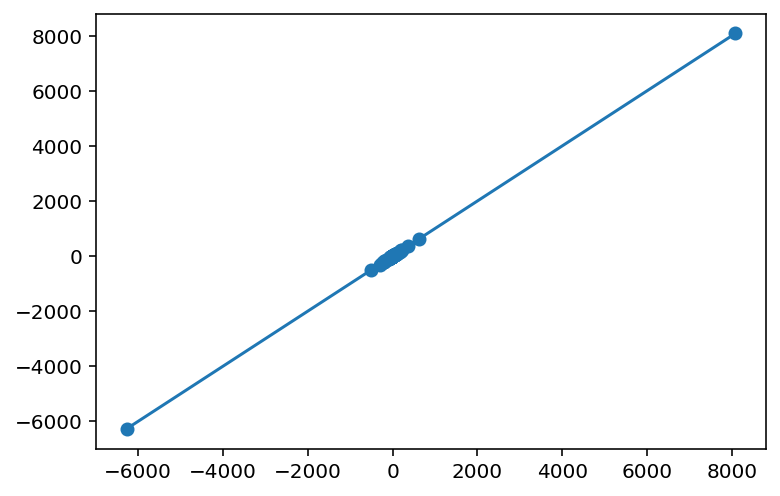

In [47]:
# Compare these
jax_val_grad = dadvi_funs_jax.kl_est_and_grad_fun(x, zs)
analytic_val_grad = dadvi_funs_analytic.kl_est_and_grad_fun(x, zs)

plt.scatter(jax_val_grad[1], analytic_val_grad[1])
plt.plot([jax_val_grad[1].min(), jax_val_grad[1].max()], [jax_val_grad[1].min(), jax_val_grad[1].max()])
print(jax_val_grad[0], analytic_val_grad[0])

In [48]:
np.allclose(jax_val_grad[1], analytic_val_grad[1])

True

In [49]:
# Now let's look at the hvp:
y = np.random.randn(2 * jax_funs['n_params']) * 1e-6

In [50]:
%%timeit
analytic_hvp = dadvi_funs_analytic.kl_est_hvp_fun(x, zs, y)

15 ms ± 417 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%%timeit
jax_hvp = dadvi_funs_jax.kl_est_hvp_fun(x, zs, y)

180 µs ± 1.82 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [52]:
# Compare values:
analytic_hvp = dadvi_funs_analytic.kl_est_hvp_fun(x, zs, y)
jax_hvp = dadvi_funs_jax.kl_est_hvp_fun(x, zs, y)

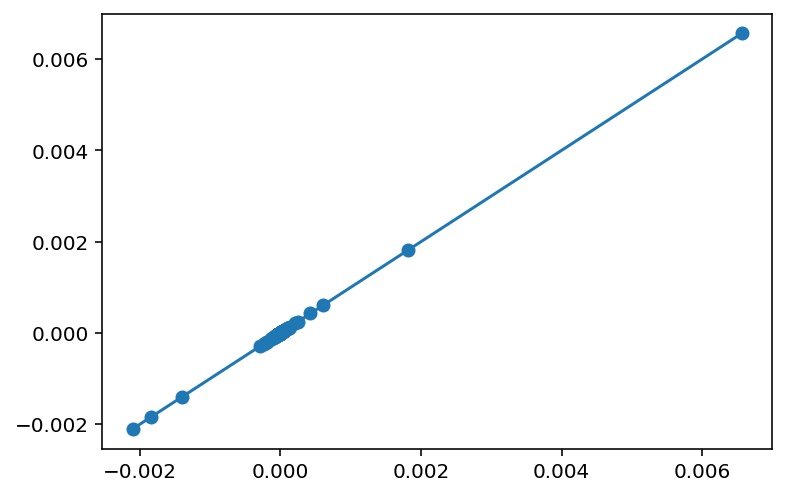

In [53]:
plt.scatter(jax_hvp, analytic_hvp)
plt.plot([jax_hvp.min(), jax_hvp.max()], [jax_hvp.min(), jax_hvp.max()])

In [54]:
np.allclose(jax_hvp, analytic_hvp)

True

In [56]:
# Both work the same way to optimise the log posterior:
dadvi_opt_analytic = find_dadvi_optimum(x, zs, dadvi_funs_analytic, verbose=True)

'f': 5410.168427550556, ||grad(f)||: 10306.689814927837
'f': 3667.948578086623, ||grad(f)||: 4050.098423528032
'f': 2875.5237070818994, ||grad(f)||: 1575.611131839815
'f': 2520.049951100832, ||grad(f)||: 621.2642436431224
'f': 2322.8565817254953, ||grad(f)||: 296.02038476146197
'f': 2176.8862265149296, ||grad(f)||: 124.74475287085085
'f': 2085.472499747124, ||grad(f)||: 175.82879880050015
'f': 1946.3388919468805, ||grad(f)||: 116.95556146401283
'f': 1757.351824982341, ||grad(f)||: 97.36783302753814
'f': 1908.7260970962518, ||grad(f)||: 904.7201391566606
'f': 1730.7196781107439, ||grad(f)||: 198.36405954300645
'f': 1676.348472084938, ||grad(f)||: 64.69969022402637
'f': 1601.0083040662746, ||grad(f)||: 70.77909009576184
'f': 1523.2274113802225, ||grad(f)||: 213.30517108657386
'f': 1474.9049676746345, ||grad(f)||: 58.122569341105525
'f': 1410.904278440768, ||grad(f)||: 157.89081002795817
'f': 1380.5522569078255, ||grad(f)||: 46.56736655306099
'f': 1336.1134973160956, ||grad(f)||: 126.2920

In [59]:
opt_params_analytic = dadvi_opt_analytic['opt_result'].x
opt_params_jax = dadvi_opt_jax['opt_result'].x

In [ ]:
# More examples on CG, LRVB etc to follow!